# Parametric non-intrusive model order reduction for 2D wildland fire model (with wind)

Here we describe the application of methods sPOD-NN, sPOD-I and POD-NN on a 2D wildland fire model with topological changes. The model equations are given in Eq.(30) and Eq.(31) of the paper. The wind velocity is considered to be (0.2, 0). The results generated in this script are shown in Sec.(3.1.3) of the paper as well.

In [1]:
import sys
sys.path.append('../sPOD/lib/')
sys.path.append('../DL-ROM/LIB/')

In [2]:
from wildfire2DNonLinear_sup import wildfire2DNonLinear_sup
import numpy as np

## Basis reconstruction for the 2D wildland fire model

In this part we : 

<ul>
<li>Load the 2D wildland fire data.</li>
<li>Perform sPOD and POD on the generated data.</li>
<li>Extract the time amplitudes according to Eq.(8) and Eq.(13) from the paper.</li>
</ul>

The inputs here include : 
<ul>
<li>$variable$ which is to be set as 0 for "Temperature" and 1 for "Supply mass fraction".</li>
<li>$test\_val$ is the parameter value at which the testing is performed.</li>
</ul>

The sPOD algorithm has to run only once for the basis reconstruction and the results necessary for subsequent steps are stored to save repeated time and effort.

In [3]:
variable = 0
test_val = 558.49

if variable == 0:
    name = "T"
else:
    name = "S"

In [4]:
import os

q = np.load(os.path.abspath(".") + '/wildfire_data/2DNonLinear/' + 'SnapShotMatrix' + str(test_val) + '.npy')
shifts_test = np.load(os.path.abspath(".") + '/wildfire_data/2DNonLinear/' + 'Shifts' + str(test_val) + '.npy')

df = wildfire2DNonLinear_sup(q, shifts_test, param_test_val=test_val, var=variable)

In [5]:
# ############################# Run shifted POD on the data ########################## (only once)
# impath = "./wildfire_data/2DNonLinear/save_Wildfire/" + name + "/"
# import os
# import pickle
# os.makedirs(impath, exist_ok=True)

# U_list, TA_list_training, TA_list_interp, spod_modes = df.run_sPOD(spod_iter=10)

# with open(impath + 'U_list.data', 'wb') as filehandle:
#     pickle.dump(U_list, filehandle)
# with open(impath + 'TA_list_training.data', 'wb') as filehandle:
#     pickle.dump(TA_list_training, filehandle)
# with open(impath + 'TA_list_interp.data', 'wb') as filehandle:
#     pickle.dump(TA_list_interp, filehandle)
# with open(impath + 'spod_modes.data', 'wb') as filehandle:
#     pickle.dump(spod_modes, filehandle)
# with open(impath + 'Q_polar_train.data', 'wb') as filehandle:
#     pickle.dump(df.q_polar_train, filehandle)

sPOD to be performed only once and the results to be stored

In [6]:
impath = "./wildfire_data/2DNonLinear/save_Wildfire/" + name + "/"
import os
import pickle

with open(impath + 'U_list.data', 'rb') as filehandle:
    U_list = pickle.load(filehandle) 
with open(impath + 'TA_list_training.data', 'rb') as filehandle:
    TA_list_training = pickle.load(filehandle)  
with open(impath + 'TA_list_interp.data', 'rb') as filehandle:
    TA_list_interp = pickle.load(filehandle) 
with open(impath + 'spod_modes.data', 'rb') as filehandle:
    spod_modes = pickle.load(filehandle) 
with open(impath + 'Q_polar_train.data', 'rb') as filehandle:
    Q_polar_train = pickle.load(filehandle)  

TA_TRAIN = np.concatenate(TA_list_training, axis=0)
SHIFTS_TRAIN = df.shift_TA_train
PARAMS_TRAIN = df.params_train
num_shift_modes = int(SHIFTS_TRAIN.shape[0])

POD

In [7]:
from sklearn.utils.extmath import randomized_svd

u, s, vt = randomized_svd(np.concatenate(df.q_train, axis=1), n_components=sum(spod_modes) + num_shift_modes)
U_POD_TRAIN = u
TA_POD_TRAIN = np.diag(s) @ vt

/opt/homebrew/Caskroom/miniforge/base/envs/PyTorch/lib/python3.9/site-packages/sklearn/utils/extmath.py:368: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


Here the testing data is assembled. The sPOD and POD are performed on the testing data and then time amplitudes and shifts are extracted. These are used for final error calculations. The sPOD on the testing data is also performed only once for saving time and effort.

In [8]:
# ##################################### Only for DoF study #######################################
# # No need to be performed again 
# # The results are shown in the paper
# from Helper import *
# from wildfire2D_sup import polar_to_cartesian, cartesian_to_polar

# frame_wise_sPOD = [1, 1]
# Nmf = spod_modes
# time_amplitudes_1 = TA_TRAIN[:Nmf[0], :]
# time_amplitudes_2 = TA_TRAIN[Nmf[0]:, :]
# frame_amplitudes_list_training = [
#     time_amplitudes_1[:frame_wise_sPOD[0], :],
#     time_amplitudes_2[:frame_wise_sPOD[1], :]
# ]

# TA_TRAIN = np.concatenate(frame_amplitudes_list_training, axis=0)
# U_list = [
#     U_list[0][:, :frame_wise_sPOD[0]],
#     U_list[1][:, :frame_wise_sPOD[1]]
# ]
# spod_modes = frame_wise_sPOD

# frame_amplitudes_list_interp = []
# for frame in range(2):
#     Nmodes = spod_modes[frame]
#     VT = frame_amplitudes_list_training[frame]
#     amplitudes = [np.reshape(VT[n, :], [df.Nsamples_train, len(df.t)]).T for n in range(Nmodes)]
#     frame_amplitudes_list_interp.append(amplitudes)

# TA_list_interp = frame_amplitudes_list_interp
# U_POD_TRAIN = U_POD_TRAIN[:, :sum(spod_modes) + num_shift_modes]
# TA_POD_TRAIN = TA_POD_TRAIN[:sum(spod_modes) + num_shift_modes, :]

# ############################################
# X_new = df.X - df.x_c  # Shift the origin to the center of the image
# Y_new = df.Y - df.y_c
# r = np.sqrt(X_new ** 2 + Y_new ** 2).flatten()  # polar coordinate r
# theta = np.arctan2(Y_new, X_new).flatten()  # polar coordinate theta
# r_i = np.linspace(np.min(r), np.max(r), df.Nx)
# theta_i = np.linspace(np.min(theta), np.max(theta), df.Ny)
# dr = r_i[1] - r_i[0]
# dtheta = theta_i[1] - theta_i[0]
# d_del = np.asarray([dr, dtheta])
# L = np.asarray([r_i[-1], theta_i[-1]])
# data_shape = [df.Nx, df.Ny, 1, df.Nsamples_train*df.Nt]
# Ndims = 2

# q1 = U_list[0] @ frame_amplitudes_list_training[0] 
# q2 = U_list[1] @ frame_amplitudes_list_training[1]
# q_train = [np.reshape(q1, newshape=data_shape), np.reshape(q2, newshape=data_shape)]

# trafos = [transforms(data_shape, L, shifts=df.shifts_train[0],
#                                    dx=d_del,
#                                    use_scipy_transform=False),
#           transforms(data_shape, L, shifts=df.shifts_train[1],
#                                    trafo_type="identity", dx=d_del,
#                                    use_scipy_transform=False)
# ]

# q_train_tmp = [np.reshape(q, newshape=[df.Nx, df.Ny, 1, df.Nt], order="F") for q in df.q_train]
# aux = []
# _, _, _, aux_tmp = cartesian_to_polar(q_train_tmp[0], df.x, df.y, df.t)
# aux.append(aux_tmp)
# for samples in range(df.Nsamples_train - 1):
#     _, _, _, tmp = cartesian_to_polar(q_train_tmp[samples + 1], df.x, df.y, df.t, fill_val=1)
#     aux.append(tmp)

# NumFrames = 2
# q_sPOD_polar = 0
# for frame in range(NumFrames):
#     q_sPOD_polar += trafos[frame].apply(q_train[frame])
# q_sPOD = np.zeros_like(q_sPOD_polar)
# for sample in range(df.Nsamples_train):
#     q_sPOD[..., sample * df.Nt:(sample+1) * df.Nt] = polar_to_cartesian(
#         q_sPOD_polar[..., sample * df.Nt:(sample+1) * df.Nt], df.t, aux[sample]
#     ) 
# ############################################
# q_POD = U_POD_TRAIN @ TA_POD_TRAIN
# ############################################
# q_sPOD = np.squeeze(np.reshape(q_sPOD, newshape=[-1, 1, df.Nsamples_train * df.Nt], order="F"))
# ############################################
# q_original = np.concatenate(df.q_train, axis=1)
# ############################################

# res = q_original - q_sPOD
# err_sPOD = np.linalg.norm(res) / np.linalg.norm(q_original)

# res = q_original - q_POD
# err_POD = np.linalg.norm(res) / np.linalg.norm(q_original)

# print("Relative reconstruction error indicator for full snapshot(sPOD) is {}".format(err_sPOD))
# print("Relative reconstruction error indicator for full snapshot(POD) is {}".format(err_POD))

In [9]:
# ############################# Run shifted POD on the test data ########################## (only once)
# import os
# impath = "./wildfire_data/2DNonLinear/save_Wildfire/" + name + "/" + str(test_val) + "/"
# import pickle
# os.makedirs(impath, exist_ok=True)

# Q_frames_test_polar, Q_frames_test_cart, conv_param = df.test_data(spod_iter=10)


# with open(impath + 'Q_frames_test_polar.data', 'wb') as filehandle:
#     pickle.dump(Q_frames_test_polar, filehandle)
# with open(impath + 'Q_frames_test_cart.data', 'wb') as filehandle:
#     pickle.dump(Q_frames_test_cart, filehandle)
# with open(impath + 'Q_test_polar.data', 'wb') as filehandle:
#     pickle.dump(df.q_polar_test, filehandle)
# with open(impath + 'conv_param.data', 'wb') as filehandle:
#     pickle.dump(conv_param, filehandle)

In [10]:
impath = "./wildfire_data/2DNonLinear/save_Wildfire/" + name + "/" + str(test_val) + "/"
import os
import pickle

with open(impath + 'Q_frames_test_polar.data', 'rb') as filehandle:
    Q_frames_test_polar = pickle.load(filehandle) 
with open(impath + 'Q_frames_test_cart.data', 'rb') as filehandle:
    Q_frames_test_cart = pickle.load(filehandle) 
with open(impath + 'Q_test_polar.data', 'rb') as filehandle:
    Q_test_polar = pickle.load(filehandle) 
with open(impath + 'conv_param.data', 'rb') as filehandle:
    conv_param = pickle.load(filehandle)
    
# Plot the frames for test parameter
df.plot_sPOD_frames(Q_frames_test_cart, plot_every=10, var_name="T")

In [11]:
mu_vecs_test = np.asarray([df.param_test_val])
params_test = [np.squeeze(np.asarray([[np.ones_like(df.t) * mu], [df.t]])) for mu in mu_vecs_test]
PARAMS_TEST = np.concatenate(params_test, axis=1)

q1_test = Q_frames_test_polar[0]
q2_test = Q_frames_test_polar[1]
time_amplitudes_1_test = U_list[0].transpose() @ q1_test
time_amplitudes_2_test = U_list[1].transpose() @ q2_test

TA_TEST = np.concatenate((time_amplitudes_1_test, time_amplitudes_2_test), axis=0)
SHIFTS_TEST = df.shift_TA_test
TA_POD_TEST = U_POD_TRAIN.transpose() @ df.q_test

We assemble the $\hat{A}$ matrix according to the Eq.(16) from the paper.

In [12]:
ta_train = np.concatenate((TA_TRAIN, SHIFTS_TRAIN), axis=0)
ta_test = np.concatenate((TA_TEST, SHIFTS_TEST), axis=0)

In [13]:
print("Grid, Nx : {}, Ny : {}, Nt : {}".format(len(df.x), len(df.y), len(df.t)))
print("Number of sPOD frames : {}".format(len(spod_modes)))
print("Number of modes (frame wise) : {}, {}".format(spod_modes[0], spod_modes[1]))
print("Size of training matrix : {} x {}".format(int(ta_train.shape[0]), int(ta_train.shape[1])))

Grid, Nx : 500, Ny : 500, Nt : 50
Number of sPOD frames : 2
Number of modes (frame wise) : 8, 4
Size of training matrix : 15 x 250


## Neural network training

Based on the data which we obtain from the previous step we train our neural network. For the training we first define certain parameters needed for training step. The parameters are mentioned here are:

<ul>
<li>$scaling$ activates the min-max data scaling for efficient training.</li>
<li>$full\_order\_model\_dimension$ is effectively $M$ which is the total number of grid points.</li>
<li>$reduced\_order\_model\_dimension$ is $n_{\mathrm{dof}}$ mentioned in Eq.(19) in the paper.</li>
<li>$totalModes$ is the total number of modes.</li>
<li>$num\_early\_stop$ defines the early stopping criteria for training step.</li>
</ul>

Subsequently the hyperparameters are:
<ul>
<li>$epochs$ sets the total number of epochs for training.</li>
<li>$lr$ sets the learning rate for training.</li>
<li>$loss\_type$ is the type of loss to consider while training options being $L1$ or $MSE$.</li>
<li>$batch\_size$ sets the total number of minibatches for the training data to be broken down into for effective training.</li>
</ul>

In [14]:
params_sPOD = {
        'scaling': True, 
        'full_order_model_dimension': len(df.x) * len(df.y),  
        'reduced_order_model_dimension': ta_train.shape[0], 
        'totalModes': ta_train.shape[0] - SHIFTS_TRAIN.shape[0], 
        'num_early_stop': 3000  
    }
params_POD = {
        'scaling': True,  
        'full_order_model_dimension': len(df.x) * len(df.y),
        'reduced_order_model_dimension': TA_POD_TRAIN.shape[0],  
        'totalModes': TA_POD_TRAIN.shape[0],  
        'num_early_stop': 3000 
    }

In [15]:
# # training the model
# from DFNN import run_model 
# import time
# tic_sPOD = time.process_time() 
# print("#################################")
# print("sPOD-NN")
# model_sPOD, _, scaling_sPOD = run_model(ta_train, PARAMS_TRAIN, epochs=200000, lr=0.005, loss_type='L1', 
#                                         logs_folder='./DNN_result/wildfire2DNonLinear/training_results_sPOD/' + name, 
#                                         params=params_sPOD, batch_size=50)
# print("#################################\n")
# toc_sPOD = time.process_time()

# tic_POD = time.process_time()
# print("#################################")
# print("POD-NN")
# model_POD, _, scaling_POD = run_model(TA_POD_TRAIN, PARAMS_TRAIN, epochs=200000, lr=0.005, loss_type='L1', 
#                                       logs_folder='./DNN_result/wildfire2DNonLinear/training_results_POD/' + name, 
#                                       params=params_POD, batch_size=50)
# print("#################################\n")
# toc_POD = time.process_time()

# print(f"Time consumption in training (sPOD-NN) : {toc_sPOD - tic_sPOD:0.4f} seconds")
# print(f"Time consumption in training (POD-NN) : {toc_POD - tic_POD:0.4f} seconds")

## Neural network prediction

After the training is finished the best weights are saved for network prediction. Here those weights are loaded and the prediction is performed.

In [16]:
import torch
import pathlib
import os
from DFNN import scale_params

# Load the correct model
log_folder_base_sPOD = 'DNN_result/wildfire2DNonLinear/training_results_sPOD/' + name + '/'
log_folder_trained_model_sPOD = sorted(pathlib.Path(log_folder_base_sPOD).glob('*/'), key=os.path.getmtime)[-1]
PATH_sPOD = str(log_folder_trained_model_sPOD) + '/trained_weights/' + 'weights.pt'

log_folder_base_POD = 'DNN_result/wildfire2DNonLinear/training_results_POD/' + name + '/'
log_folder_trained_model_POD = sorted(pathlib.Path(log_folder_base_POD).glob('*/'), key=os.path.getmtime)[-1]
PATH_POD = str(log_folder_trained_model_POD) + '/trained_weights/' + 'weights.pt'

# T
PATH_sPOD = 'DNN_result/wildfire2DNonLinear/training_results_sPOD/' + name + '/2023_12_12__16-27-22/trained_weights/weights.pt'
PATH_POD = 'DNN_result/wildfire2DNonLinear/training_results_POD/' + name + '/2023_12_12__16-28-45/trained_weights/weights.pt'

# S
# PATH_sPOD = 'DNN_result/wildfire2DNonLinear/training_results_sPOD/' + name + '/2023_12_13__17-11-33/trained_weights/weights.pt'
# PATH_POD = 'DNN_result/wildfire2DNonLinear/training_results_POD/' + name + '/2023_12_13__17-12-12/trained_weights/weights.pt'

# Scale the parameters before prediction
if '/trained_weights/weights.pt' in PATH_sPOD: address_sPOD = PATH_sPOD.replace('/trained_weights/weights.pt', '')
scaling_sPOD = np.load(address_sPOD + '/variables/' + 'scaling.npy', allow_pickle=True)

if '/trained_weights/weights.pt' in PATH_POD: address_POD = PATH_POD.replace('/trained_weights/weights.pt', '')
scaling_POD = np.load(address_POD + '/variables/' + 'scaling.npy', allow_pickle=True)

PARAMS_TEST_sPOD = scale_params(PARAMS_TEST, params_sPOD, scaling_sPOD)
PARAMS_TEST_POD = scale_params(PARAMS_TEST, params_POD, scaling_POD)

cpu


In [17]:
# testing the model
from DFNN import test_model 
import time 

tic = time.process_time()
rel_err_sPOD, results_predicted_sPOD = test_model(ta_test, PARAMS_TEST_sPOD, trained_model=None, saved_model=True, 
                                                  PATH_TO_WEIGHTS=PATH_sPOD, params=params_sPOD, scaling=scaling_sPOD, 
                                                  batch_size=50) 
toc = time.process_time()
print(f"Time consumption in testing sPOD-NN model : {toc - tic:0.4f} seconds")

tic = time.process_time()
rel_err_POD, results_predicted_POD = test_model(TA_POD_TEST, PARAMS_TEST_POD, trained_model=None, saved_model=True, 
                                                PATH_TO_WEIGHTS=PATH_POD, params=params_POD, scaling=scaling_POD, 
                                                batch_size=50)
toc = time.process_time()
print(f"Time consumption in testing POD-NN model : {toc - tic:0.4f} seconds")

Time consumption in testing sPOD-NN model : 0.0039 seconds
Time consumption in testing POD-NN model : 0.0014 seconds


Once the predictions for the time amplitudes and the shifts had been made we now reconstruct the snapshot according to Eq.(11) and Eq.(18) for POD and sPOD based methods respectively

In [18]:
frame_amplitudes_predicted_sPOD = results_predicted_sPOD[:-SHIFTS_TRAIN.shape[0], :]
shifts_predicted_sPOD = results_predicted_sPOD[-SHIFTS_TRAIN.shape[0]:, :]
frame_amplitudes_predicted_POD = results_predicted_POD

#############################################
Online Error checks
init shift matrix ...
Setting up the shift matrices, with interpolation order:
Forward T^k:     O(h^3)
Backward T^(-k): O(h^3)
Check 1...
Relative error indicator for shift for frame 1 (sPOD-NN): 0.012552756909836494
Relative error indicator for shift for frame 1 (sPOD-I): 0.010698928818387006
Check 2...
Relative time amplitude error indicator (polar) for frame 1 (sPOD-NN): 0.14474091945905482
Relative time amplitude error indicator (polar) for frame 2 (sPOD-NN): 0.29086152392562825
Relative time amplitude error indicator (polar) for frame 1 (sPOD-I): 0.14021079742640144
Relative time amplitude error indicator (polar) for frame 2 (sPOD-I): 0.3205627298854118
Relative time amplitude error indicator (polar) (POD-NN): 0.048554594893176026
init shift matrix ...
Setting up the shift matrices, with interpolation order:
Forward T^k:     O(h^3)
Backward T^(-k): O(h^3)
Check 3...
Relative reconstruction error indicator for full s

/opt/homebrew/Caskroom/miniforge/base/envs/PyTorch/lib/python3.9/site-packages/tikzplotlib/_save.py:389: UserWarning: tikzplotlib: Don't know how to handle object <class 'matplotlib.figure.SubFigure'>.
  warnings.warn(


Timing...
Time consumption in assembling the transformation operators (sPOD-NN) : 15.9901 seconds
Time consumption in assembling the transformation operators (sPOD-I) : 14.7195 seconds
Time consumption in assembling the final solution (sPOD-NN) : 1.8249 seconds
Time consumption in assembling the final solution (sPOD-I)  : 3.0033 seconds
Time consumption in assembling the final solution (POD-NN)  : 0.3408 seconds
Time consumption in converting from cart-polar-cart  : 3.1887 seconds


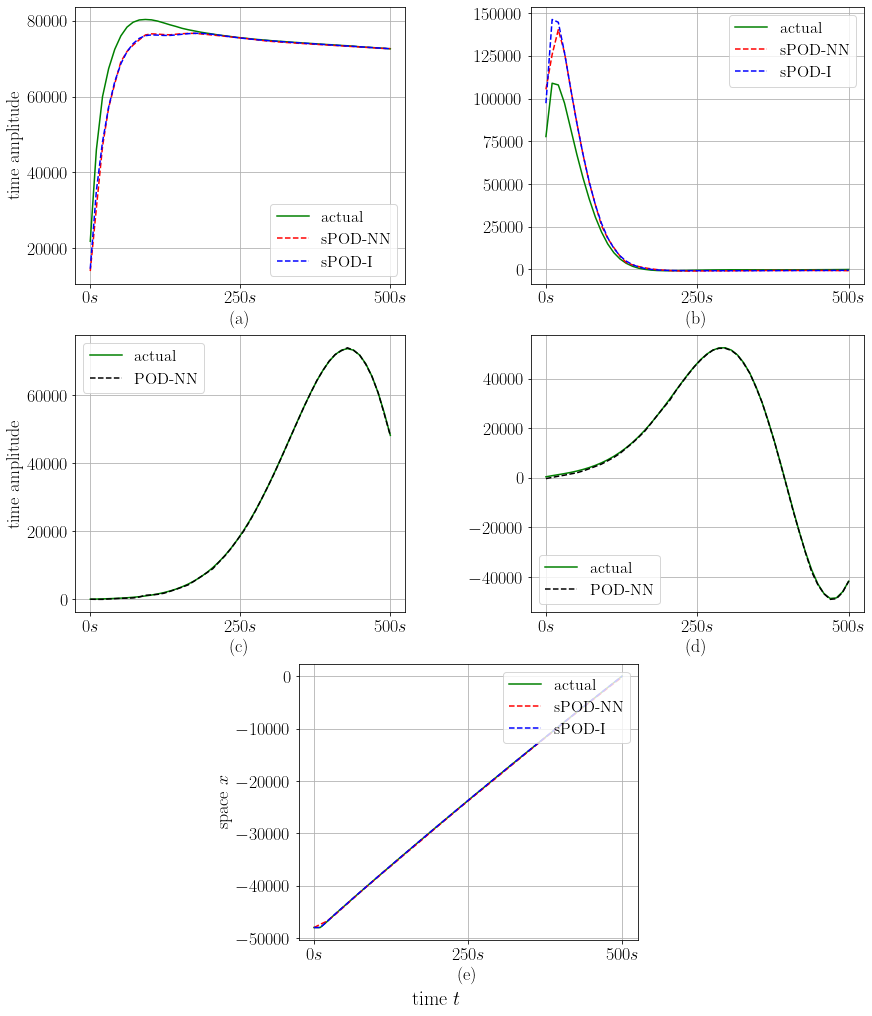

In [19]:
Q_recon_sPOD_cart, Q_recon_POD_cart, Q_recon_interp_cart, errors, errors_inf = df.plot_online_data(frame_amplitudes_predicted_sPOD, 
                                                                                       frame_amplitudes_predicted_POD, 
                                                                                       TA_TEST, TA_POD_TEST, TA_list_interp,
                                                                                       shifts_predicted_sPOD, SHIFTS_TEST, 
                                                                                       spod_modes, U_list, U_POD_TRAIN, 
                                                                                       Q_test_polar, Q_frames_test_polar,
                                                                                       conv_param, plot_online=True)

In [20]:
df.plot_recon(Q_recon_sPOD_cart, Q_recon_POD_cart, Q_recon_interp_cart, t_a=10, t_b=50)
df.plot_recon_video(Q_recon_sPOD_cart, Q_recon_POD_cart, Q_recon_interp_cart, plot_every=2)

## Reconstruction error plots

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import os
from Helper import save_fig
from statistics import mean

impath = "../plots/images_wildfire2DNonLinear/"
os.makedirs(impath, exist_ok=True) 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"]})

SMALL_SIZE = 14   # 16
MEDIUM_SIZE = 18   # 18
BIGGER_SIZE = 20   # 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

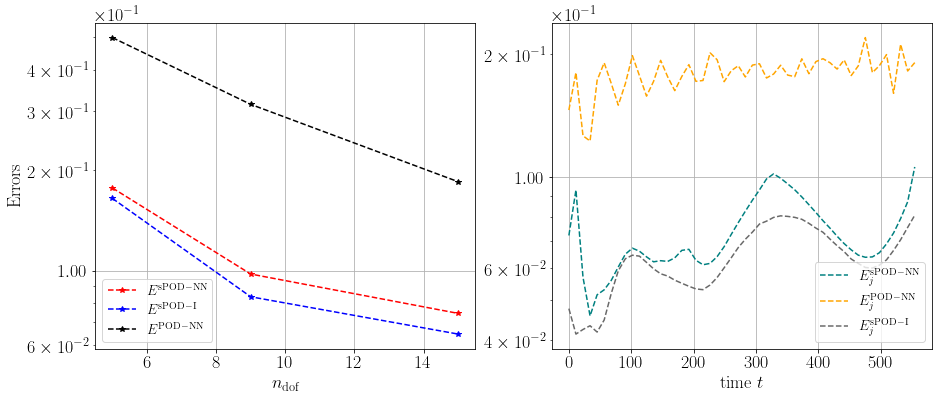

In [27]:
from matplotlib.ticker import ScalarFormatter

truncated_modes = np.array([2 + 3, 6 + 3, 12 + 3])
E_sPOD_NN = np.array([0.17684, 0.09765, 0.07444])
E_sPOD_I = np.array([0.16456, 0.08348, 0.06454])
E_POD_NN = np.array([0.49865, 0.31465, 0.18456])

err_1 = errors[0]
err_2 = errors[1]
err_3 = errors[2]

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Create one ScalarFormatter for log axis
sf = ScalarFormatter(useMathText=True)
sf.set_powerlimits((0, 0))

axs[0].semilogy(truncated_modes, E_sPOD_NN, color="red", linestyle='--', marker="*", label=r"$E^{\mathrm{sPOD-NN}}$")
axs[0].semilogy(truncated_modes, E_sPOD_I, color="blue", linestyle='--', marker="*", label=r"$E^{\mathrm{sPOD-I}}$")
axs[0].semilogy(truncated_modes, E_POD_NN, color="black", linestyle='--', marker="*", label=r"$E^{\mathrm{POD-NN}}$")
axs[0].set_xlabel(r"$n_{\mathrm{dof}}$")
axs[0].set_ylabel('Errors')
axs[0].grid()
axs[0].yaxis.set_major_formatter(sf)
axs[0].legend(loc='lower left')

axs[1].semilogy(df.t, err_1, color="teal", linestyle='--', label=r"$E^{\mathrm{sPOD-NN}}_j$")
axs[1].semilogy(df.t, err_2, color="orange", linestyle='--', label=r"$E^{\mathrm{POD-NN}}_j$")
axs[1].semilogy(df.t, err_3, color="dimgrey", linestyle='--', label=r"$E^{\mathrm{sPOD-I}}_j$")
axs[1].set_xlabel(r"time $t$")
axs[1].grid()
axs[1].yaxis.set_major_formatter(sf)
axs[1].legend(loc='lower right')


save_fig(filepath=impath + 'Rel_err_2D_nonlinear', figure=fig)
fig.savefig(impath + "Rel_err_2D_nonlinear" + ".pdf", format='pdf',dpi=200, transparent=True, bbox_inches="tight")

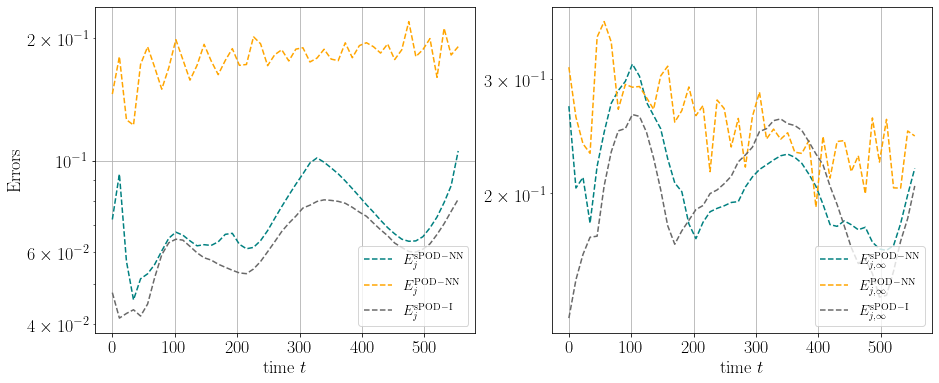

In [23]:
err_1 = errors[0]
err_2 = errors[1]
err_3 = errors[2]

err_1_inf = errors_inf[0]
err_2_inf = errors_inf[1]
err_3_inf = errors_inf[2]

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].semilogy(df.t, err_1, color="teal", linestyle='--', label=r"$E^{\mathrm{sPOD-NN}}_j$")
axs[0].semilogy(df.t, err_2, color="orange", linestyle='--', label=r"$E^{\mathrm{POD-NN}}_j$")
axs[0].semilogy(df.t, err_3, color="dimgrey", linestyle='--', label=r"$E^{\mathrm{sPOD-I}}_j$")
axs[0].set_ylabel('Errors')
axs[0].set_xlabel(r"time $t$")
axs[0].grid()
axs[0].legend(loc='lower right')

axs[1].semilogy(df.t, err_1_inf, color="teal", linestyle='--', label=r"$E^{\mathrm{sPOD-NN}}_{j, \infty}$")
axs[1].semilogy(df.t, err_2_inf, color="orange", linestyle='--', label=r"$E^{\mathrm{POD-NN}}_{j, \infty}$")
axs[1].semilogy(df.t, err_3_inf, color="dimgrey", linestyle='--', label=r"$E^{\mathrm{sPOD-I}}_{j, \infty}$")
axs[1].set_xlabel(r"time $t$")
axs[1].grid()
axs[1].legend(loc='lower right')


save_fig(filepath=impath + 'Rel_err_nl', figure=fig)
fig.savefig(impath + "Rel_err_nl" + ".pdf", format='pdf',dpi=200, transparent=True, bbox_inches="tight")

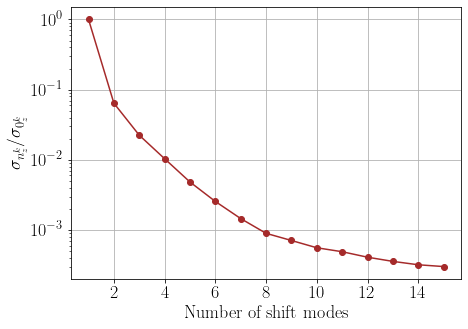

In [24]:
from matplotlib.ticker import MaxNLocator

rank = 15
U, SIG, VH = np.linalg.svd(np.squeeze(df.shifts_train[0][0, ...]), full_matrices=False)
rel_err_list = [np.linalg.norm(np.squeeze(df.shifts_train[0][0, ...]) - U[:, :r+1].dot(np.diag(SIG[:r+1]).dot(VH[:r+1, :]))) / np.linalg.norm(np.squeeze(df.shifts_train[0][0, ...])) for r in range(rank)]
fig, ax = plt.subplots(figsize=(7, 5))
ax.semilogy(np.arange(rank) + 1, SIG[:rank] / SIG[0], color="brown", marker="o")
ax.set_xlabel("Number of shift modes")
ax.set_ylabel(r"$\sigma_{n^k_{z}} / \sigma_{0^k_{z}}$")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid()
save_fig(filepath=impath + 'shift_svd', figure=fig)
fig.savefig(impath + "shift_svd" + ".pdf", format='pdf',dpi=200, transparent=True, bbox_inches="tight")  